In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('/kaggle/input/ecommerce-text-classification/ecommerceDataset.csv')

In [3]:
len(data)

50424

In [8]:
#rename columns
data.columns = ['label', 'text']

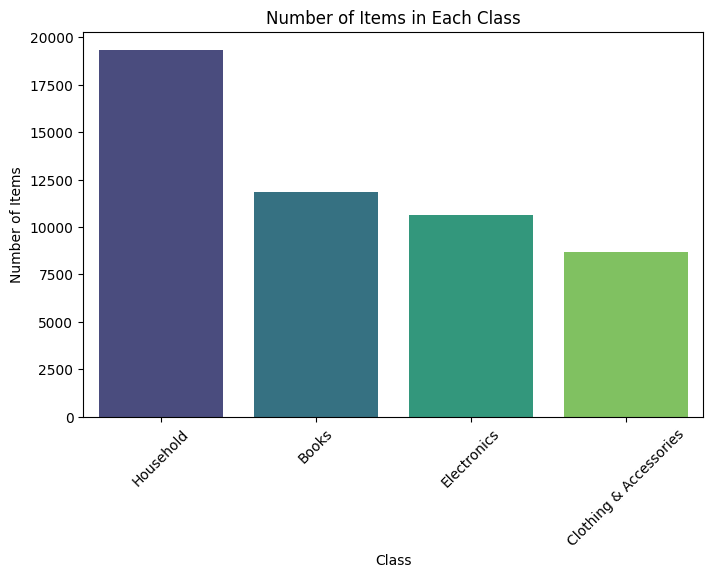

In [25]:
def plot_count(data):
    # Count occurrences of each class
    class_counts = data["label"].value_counts()
    
    # Plot the class distribution
    plt.figure(figsize=(8, 5))
    sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
    
    # Add labels and title
    plt.xlabel("Class")
    plt.ylabel("Number of Items")
    plt.title("Number of Items in Each Class")
    plt.xticks(rotation=45)  # Rotate x labels if needed
    plt.show()

plot_count(data)

# note:the data is unbalanced
* so we need to use stratify spliting

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X, y = data['text'], data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [21]:
#check if the data splited using stratify
y_test.value_counts(), y_test.value_counts()/0.2

(label
 Household                 3863
 Books                     2364
 Electronics               2124
 Clothing & Accessories    1734
 Name: count, dtype: int64,
 label
 Household                 19315.0
 Books                     11820.0
 Electronics               10620.0
 Clothing & Accessories     8670.0
 Name: count, dtype: float64)

In [22]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re

# Get English stopwords as a set (faster lookup)
stop_words = set(stopwords.words('english'))

def preprocess(text):
    '''
    Apply text preprocessing: lowercase, remove special characters, and remove stopwords.
    '''
    text = text.lower()  # Lowercase
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    tokens = text.split()  # Tokenize
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return " ".join(tokens)

# Apply preprocessing to X_test (ensure it's a Series)
X_test = X_test.astype(str).apply(preprocess)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
X_train = X_train.astype(str).apply(preprocess)

In [27]:
X_train[0]

'saf floral framed painting wood 30 inch x 10 inch special effect uv print textured sao297 painting made synthetic frame uv textured print gives multi effects attracts towards special series paintings makes wall beautiful gives royal touch perfect gift special ones'

In [28]:
data.iloc[0,1]

"SAF 'Floral' Framed Painting (Wood, 30 inch x 10 inch, Special Effect UV Print Textured, SAO297) Painting made up in synthetic frame with UV textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch (A perfect gift for your special ones)."

In [29]:
import numpy as np
from collections import defaultdict

class NaiveBayesClassifier:
    def __init__(self):
        self.class_probs = {}  # P(Class)
        #word_counts[label][word] initializes to 0 when first accessed, avoiding errors.
        self.word_probs = defaultdict(lambda: defaultdict(float))  # P(Word|Class)
        self.vocab = set()  # Unique words

    def fit(self, X_train, y_train):
        '''
        Train Naïve Bayes model
        '''
        class_counts = defaultdict(int)  # Count of each class
        word_counts = defaultdict(lambda: defaultdict(int))  # Word count per class
        total_docs = len(y_train)

        # Count word occurrences in each class
        for text, label in zip(X_train, y_train):
            class_counts[label] += 1
            words = text.split()
            for word in words:
                word_counts[label][word] += 1
                self.vocab.add(word)  # Add to vocabulary
        
        # Compute class probabilities P(Class)
        self.class_probs = {label: np.log(count / total_docs) for label, count in class_counts.items()}

        # Compute P(Word|Class) using Laplace smoothing
        for label, words in word_counts.items():
            total_words = sum(words.values()) + len(self.vocab)  # Laplace smoothing
            self.word_probs[label] = {word: np.log((count + 1) / total_words) for word, count in words.items()}

    def predict(self, X_test):
        '''
        Predict class labels for test data
        '''
        predictions = []
        for text in X_test:
            words = text.split()
            class_scores = {}
                
            for label in self.class_probs:
                score = self.class_probs[label]  # Start with log P(Class)
                for word in words:
                    if word in self.word_probs[label]:  
                        score += self.word_probs[label][word]  # Add log P(Word|Class)
                class_scores[label] = score

            predictions.append(max(class_scores, key=class_scores.get))  # Pick highest score
        return predictions


In [30]:
nb = NaiveBayesClassifier()
nb.fit(X_train, y_train)

# Predict on test data
X_test_processed = X_test.astype(str).apply(preprocess)
y_pred = nb.predict(X_test_processed)


In [31]:

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.1690


In [32]:
y_pred[:5], y_test[:5]

(['Household',
  'Clothing & Accessories',
  'Clothing & Accessories',
  'Books',
  'Clothing & Accessories'],
 25671          Books
 3088       Household
 48452    Electronics
 21468          Books
 21766          Books
 Name: label, dtype: object)

In [38]:
y_pred_df = pd.DataFrame(y_pred, columns=['label'])

prediciton distribution


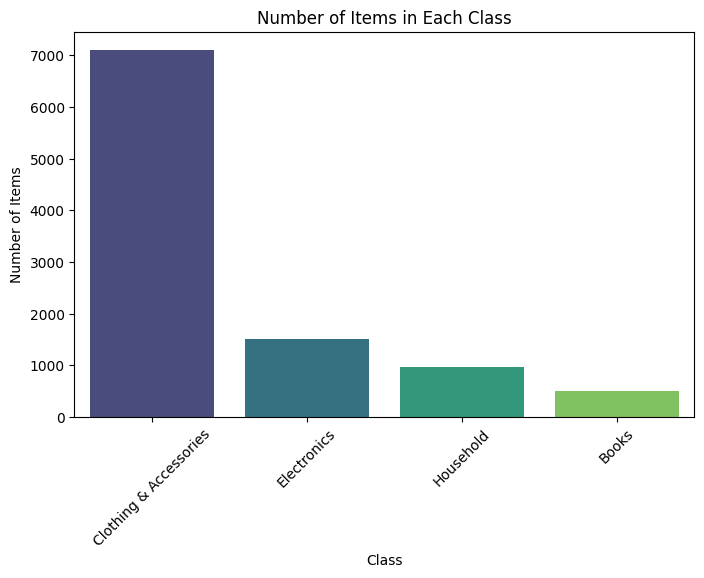

In [42]:
print('prediciton distribution')
plot_count(y_pred_df)

actual distribution


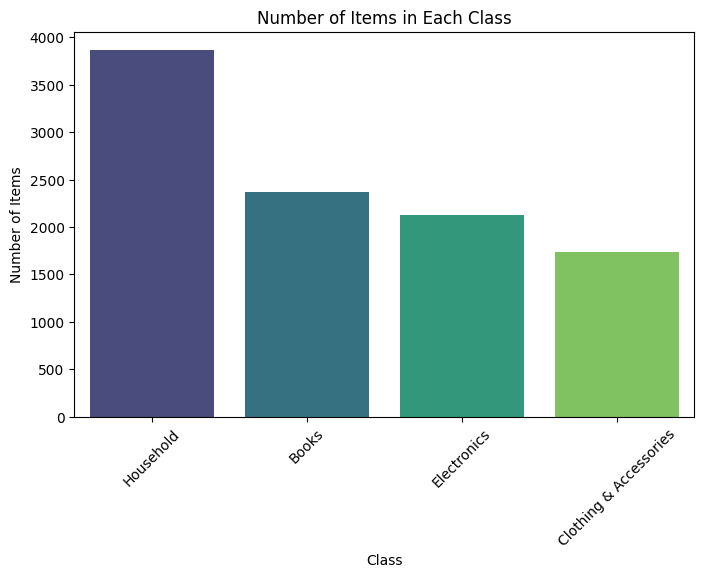

In [43]:
print('actual distribution')
plot_count(pd.DataFrame(y_test, columns=['label']))

# why the accuracy is so bad
because in the test data there are some words that are not in the training data, these words during the prediction have probability of 0, and multipling with 0 make the output is zero 

In [44]:
#with smoothing
import numpy as np
from collections import defaultdict

class NaiveBayesClassifier:
    def __init__(self, alpha=1.0):  # Alpha is the smoothing parameter
        self.alpha = alpha
        self.class_probs = {}  # P(Class)
        self.word_probs = defaultdict(lambda: defaultdict(float))  # P(Word | Class)
        self.vocab = set()  # Unique words

    def fit(self, X_train, y_train):
        '''
        Train Naïve Bayes model
        '''
        class_counts = defaultdict(int)  # Count of each class
        word_counts = defaultdict(lambda: defaultdict(int))  # Word count per class
        total_docs = len(y_train)

        # Count occurrences
        for text, label in zip(X_train, y_train):
            class_counts[label] += 1
            words = text.split()
            for word in words:
                word_counts[label][word] += 1
                self.vocab.add(word)  # Add to vocabulary

        # Compute P(Class) (log probabilities for stability)
        self.class_probs = {label: np.log(count / total_docs) for label, count in class_counts.items()}

        # Compute P(Word | Class) using Laplace smoothing
        for label, words in word_counts.items():
            total_words = sum(words.values())  # Total words in this class
            denom = total_words + self.alpha * len(self.vocab)  # Smoothing

            self.word_probs[label] = {
                word: np.log((count + self.alpha) / denom) for word, count in words.items()
            }

    def predict(self, X_test):
        '''
        Predict class labels for test data
        '''
        predictions = []
        for text in X_test:
            words = text.split()
            class_scores = {}

            for label in self.class_probs:
                score = self.class_probs[label]  # Start with P(Class)
                for word in words:
                    score += self.word_probs[label].get(word, np.log(self.alpha / (self.alpha * len(self.vocab))))  # Default smoothing for unknown words
                class_scores[label] = score

            predictions.append(max(class_scores, key=class_scores.get))  # Pick highest probability class
        return predictions


In [45]:
# Train the Naïve Bayes classifier
nb = NaiveBayesClassifier(alpha=1.0)  # Laplace smoothing
nb.fit(X_train, y_train)

# Preprocess test data
X_test_processed = X_test.astype(str).apply(preprocess)

# Predict on test data
y_pred = nb.predict(X_test_processed)

# Evaluate performance
from sklearn.metrics import accuracy_score
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


Accuracy: 0.9322


prediciton distribution


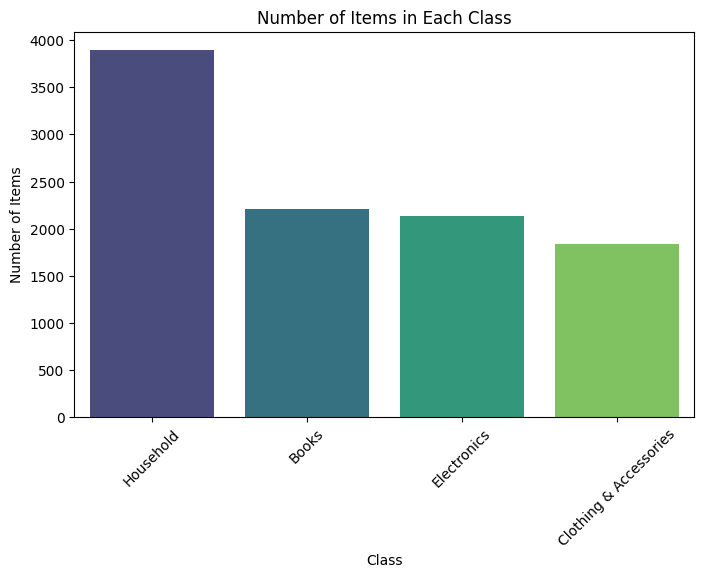

actual distribution


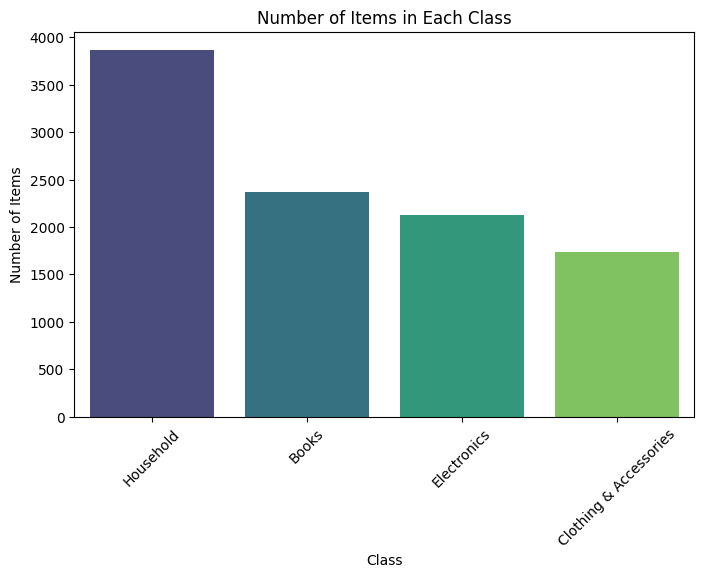

In [46]:
y_pred_df = pd.DataFrame(y_pred, columns=['label'])
print('prediciton distribution')
plot_count(y_pred_df)
print('actual distribution')
plot_count(pd.DataFrame(y_test, columns=['label']))

In [47]:
errors = pd.DataFrame()
errors['text'] = X_test[y_pred != y_test]
errors['y'] = y_test[y_pred != y_test]
errors['y_pred'] = np.array(y_pred)[y_pred != y_test]

In [48]:
errors.loc[errors['y'] == 'Books']

,text,y,y_pred
25671,sports hour pool chalk pack 12 pcs billiards c...,Books,Household
23554,action shoes black orange sports shoes one nee...,Books,Clothing & Accessories
25714,kuber industries fabric 73 cms black jumbo att...,Books,Household
20616,baby touch playbook author lemon ribbon studio...,Books,Clothing & Accessories
23561,action campus t941 sport shoes men size 9 uk,Books,Clothing & Accessories
...,...,...,...
28420,essentials audiology,Books,Household
24741,tickright mini wooden photo clips rope used ho...,Books,Household
20135,wings fire wings fire,Books,Clothing & Accessories
22144,bharat ki rajvayvastha,Books,Household


In [49]:
errors['y'].value_counts()

y
Household                 244
Books                     234
Electronics               172
Clothing & Accessories     34
Name: count, dtype: int64

In [50]:
len(y_test[y_pred != y_test])

684

In [51]:
len(y_test)

10085

In [54]:
for alpha in np.linspace(2,4,20):
    nb = NaiveBayesClassifier(alpha=alpha)
    nb.fit(X_train, y_train)
    y_pred = nb.predict(X_test)
    print(f"Alpha={alpha}, Accuracy={accuracy_score(y_test, y_pred):.4f}")

Alpha=2.0, Accuracy=0.9341
Alpha=2.1052631578947367, Accuracy=0.9345
Alpha=2.2105263157894735, Accuracy=0.9344
Alpha=2.3157894736842106, Accuracy=0.9346
Alpha=2.4210526315789473, Accuracy=0.9348
Alpha=2.526315789473684, Accuracy=0.9343
Alpha=2.6315789473684212, Accuracy=0.9343
Alpha=2.736842105263158, Accuracy=0.9344
Alpha=2.8421052631578947, Accuracy=0.9346
Alpha=2.9473684210526314, Accuracy=0.9346
Alpha=3.052631578947368, Accuracy=0.9345
Alpha=3.1578947368421053, Accuracy=0.9342
Alpha=3.263157894736842, Accuracy=0.9342
Alpha=3.3684210526315788, Accuracy=0.9341
Alpha=3.473684210526316, Accuracy=0.9343
Alpha=3.5789473684210527, Accuracy=0.9342
Alpha=3.6842105263157894, Accuracy=0.9342
Alpha=3.789473684210526, Accuracy=0.9331
Alpha=3.894736842105263, Accuracy=0.9326
Alpha=4.0, Accuracy=0.9327


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF transformer
vectorizer = TfidfVectorizer()

# Transform train and test data
X_train_tfidf = vectorizer.fit_transform(X_train)  # Fit & transform training data
X_test_tfidf = vectorizer.transform(X_test)  # Only transform test data

import numpy as np
from collections import defaultdict

class NaiveBayesTFIDF:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_probs = {}  # P(Class)
        self.word_probs = defaultdict(lambda: defaultdict(float))  # P(Word | Class)
        self.vocab = set()  # Unique words

    def fit(self, X_train_tfidf, y_train):
        '''
        Train Naïve Bayes model using TF-IDF values
        '''
        class_counts = defaultdict(int)  # Count of each class
        word_tfidf = defaultdict(lambda: defaultdict(float))  # TF-IDF sum per class
        total_docs = len(y_train)

        # Sum TF-IDF values per class
        for i, label in enumerate(y_train):
            class_counts[label] += 1
            for j in X_train_tfidf[i].nonzero()[1]:  # Get nonzero TF-IDF words
                word_tfidf[label][j] += X_train_tfidf[i, j]
                self.vocab.add(j)  # Store word index

        # Compute P(Class) (log probabilities)
        self.class_probs = {label: np.log(count / total_docs) for label, count in class_counts.items()}

        # Compute P(Word | Class) using Laplace smoothing
        for label, words in word_tfidf.items():
            total_tfidf = sum(words.values())  # Total TF-IDF sum in this class
            denom = total_tfidf + self.alpha * len(self.vocab)  # Smoothing

            self.word_probs[label] = {
                word: np.log((tfidf + self.alpha) / denom) for word, tfidf in words.items()
            }

    def predict(self, X_test_tfidf):
        '''
        Predict class labels for test data using TF-IDF
        '''
        predictions = []
        for i in range(X_test_tfidf.shape[0]):  # For each test sample
            class_scores = {}

            for label in self.class_probs:
                score = self.class_probs[label]  # Start with P(Class)
                for j in X_test_tfidf[i].nonzero()[1]:  # Get nonzero TF-IDF words
                    score += self.word_probs[label].get(j, np.log(self.alpha / (self.alpha * len(self.vocab))))  # Handle unknown words
                class_scores[label] = score

            predictions.append(max(class_scores, key=class_scores.get))  # Pick highest probability class
        return predictions

# Train the classifier
nb_tfidf = NaiveBayesTFIDF(alpha=1.0)
nb_tfidf.fit(X_train_tfidf, y_train)

# Predict on test data
y_pred = nb_tfidf.predict(X_test_tfidf)

# Evaluate accuracy
from sklearn.metrics import accuracy_score
print(f"Accuracy with TF-IDF: {accuracy_score(y_test, y_pred):.4f}")
